In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import datetime
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

In [2]:
url_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_global = pd.read_csv(url_global)

url_us = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df_us = pd.read_csv(url_us)

In [3]:
### MANUAL UPLOAD ###
#from google.colab import files
#uploaded = files.upload()
#import io
#df2 = pd.read_csv(io.BytesIO(uploaded['time_series_19-covid-Confirmed.csv']), header=0, parse_dates=True, squeeze=True)
# Dataset is now stored in a Pandas Dataframe

In [4]:
## CONSTANTS ##
US_START_DATE = '3/10/20'
FORMAT_DATE_SOURCE = '%m/%d/%y'
FORMAT_DATE_DISPLAY = '%m-%d'
NUM_CHARTS_IN_ROW = 2
CHART_WIDTH_DEFAULT = 8
CHART_HEIGHT_DEFAULT = 5

In [5]:
register_matplotlib_converters()

def set_ax_info(ax, title, xlabel, ylabel, format_display='%m-%d', legend_loc=2):
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.xaxis_date()
  ax.xaxis.set_major_formatter(mdates.DateFormatter(format_display))
  ax.set_ylabel(ylabel)
  ax.legend(loc=legend_loc)

def plot_data(df_list, titles, xlabels, ylabels, format_display=None, legend_loc=None,
              start_date=None, x_val_list=[]):
  row_num = len(df_list)//NUM_CHARTS_IN_ROW
  if row_num == 0 or len(df_list)%NUM_CHARTS_IN_ROW != 0:
    row_num += 1

  fig = plt.figure(
      figsize=(CHART_WIDTH_DEFAULT*NUM_CHARTS_IN_ROW,
               CHART_HEIGHT_DEFAULT*row_num), constrained_layout=True)
  spec = gridspec.GridSpec(ncols=NUM_CHARTS_IN_ROW, nrows=row_num, figure=fig)

  subplots = []
  for i in range(len(df_list)):
    subplots.append(fig.add_subplot(spec[i//NUM_CHARTS_IN_ROW, i%NUM_CHARTS_IN_ROW]))

  if start_date:
    date_start_index = list(df_list[0].keys()).index(start_date)
  else:
    date_start_index = 0

  if not x_val_list:
    x_val_list = []
    for df in df_list:
      x_val_list.append(
          list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), 
                   df.keys()[date_start_index:])))

  for index, df in enumerate(df_list):
    for row_num, row in df.iterrows():
      subplots[index].plot(x_val_list[index], row.values[date_start_index:], label=row_num)
    set_ax_info(subplots[index], titles[index], xlabels[index], ylabels[index])
  
  fig.show()
  fig.canvas.flush_events()

# Confirmed Cases and Delta By Country #

In [6]:
countries = ['France', 'India', 'Italy', 'Japan', 'Korea, South', 'Singapore', 'US']
countries_asia = ['India', 'Japan', 'Korea, South', 'Singapore']

# All countries
df_countries = df_global[df_global['Country/Region'].isin(countries)].groupby(
    'Country/Region').sum()
df_countries = df_countries[df_countries.columns[2:]]
df_countries_diffs = df_countries.diff(axis=1)
df_countries_diffs_retroactive = df_countries.diff(periods=-1, axis=1).multiply(-100)
countries_diffs_retroactive = []
for row_num, row in df_countries_diffs_retroactive.iterrows():
  countries_diffs_retroactive.append(row.div(df_countries_diffs.loc[row_num]))
df_countries_diffs_retroactive = pd.DataFrame(countries_diffs_retroactive)

# Asian countries
df_countries_asia = df_global[df_global['Country/Region'].isin(countries_asia)].groupby(
    'Country/Region').sum()
df_countries_asia = df_countries_asia[df_countries_asia.columns[2:]]
df_countries_asia = df_countries_asia.diff(axis=1)
df_countries_asia_diffs = df_countries_asia.diff(axis=1)
df_countries_asia_diffs_retroactive = df_countries_asia_diffs.diff(periods=-1, axis=1).multiply(-100)
countries_asia_diffs_retroactive = []
for row_num, row in df_countries_asia_diffs_retroactive.iterrows():
  countries_asia_diffs_retroactive.append(row.div(df_countries_asia_diffs.loc[row_num]))
df_countries_asia_diffs_retroactive = pd.DataFrame(countries_asia_diffs_retroactive)

df_list = [df_countries,
           df_countries_asia,
           df_countries_diffs,
           df_countries_asia_diffs,
           df_countries_diffs_retroactive,
           df_countries_asia_diffs_retroactive]
titles = ['Confirmed cases by country over time', 
          'Confirmed cases by country over time - Asia', 
          'Daily confirmed case delta by country over time', 
          'Daily confirmed case delta by country over time - Asia',
          'Daily confirmed case % delta by country over time',
          'Daily confirmed case % delta by country over time - Asia']
xlabels = ['Date', 'Date', 'Date', 'Date', 'Date', 'Date']
ylabels = ['Confirmed cases', 'Confirmed cases', 'Delta', 'Delta', '% Delta', '% Delta']

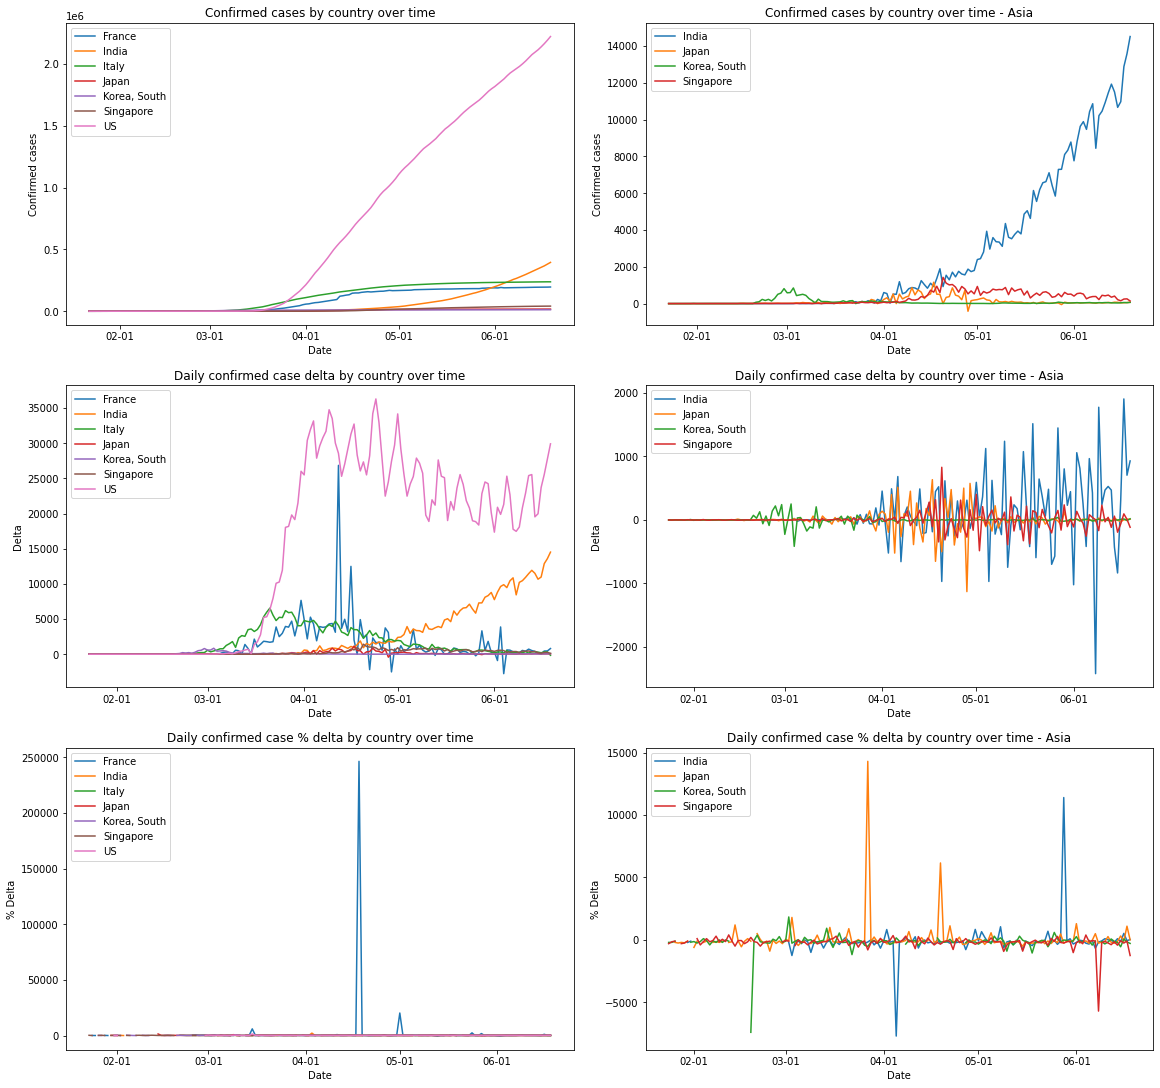

In [7]:
plot_data(df_list, titles, xlabels, ylabels)

# Confirmed Cases Analysis by US State #

In [8]:
states = ['California', 'Michigan', 'New York', 'Washington']
df_states = df_us[df_us['Province_State'].isin(states)]
df_states.set_index('Province_State', inplace=True)
df_states = df_states[df_states.columns[9:]]
df_states = df_states.groupby('Province_State').sum()

In [9]:
# Merge Current State Population Numbers
population = {
    'state': ['California', 'Michigan', 'New York', 'Washington'],
    'population': [39.56 * 1000000, 9.996 * 1000000, 8.623 * 100000, 7.536 * 1000000]
}
df_population = pd.DataFrame.from_dict(population)

In [10]:
states_per_capita = []
for row_num, row in df_states.iterrows():
  states_per_capita.append(row/int((df_population['population'][df_population['state'] == row_num])))
df_states_per_capita = pd.DataFrame(states_per_capita)

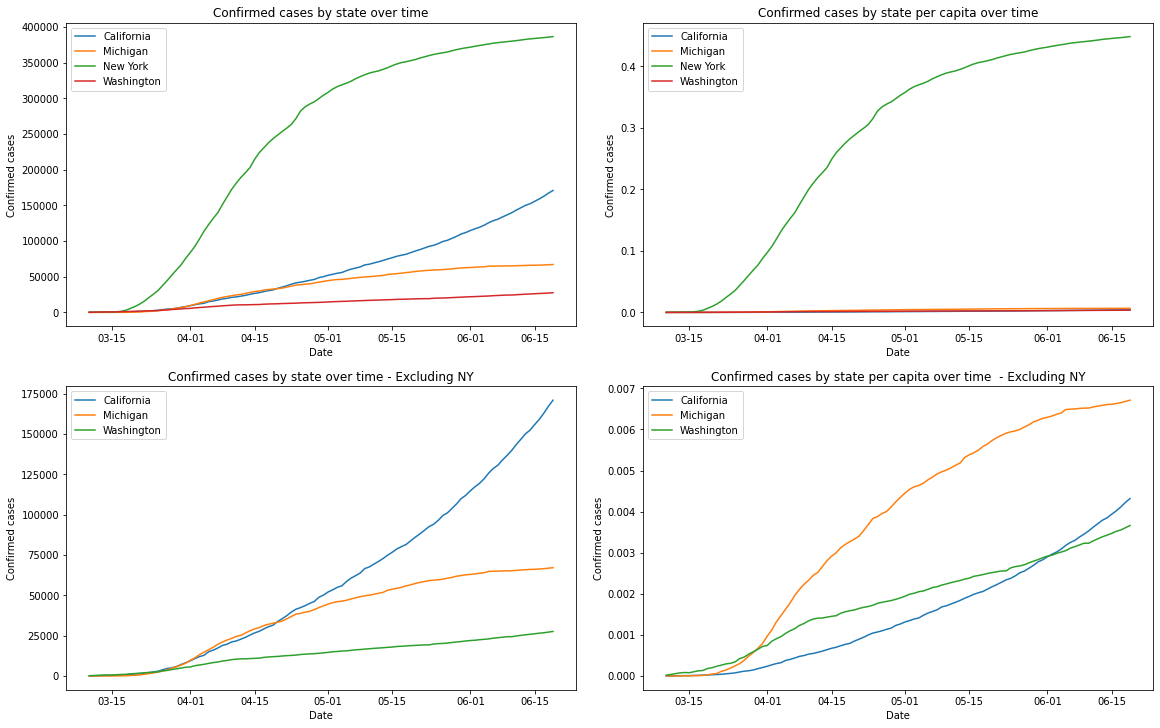

In [11]:
dfs = [df_states,
       df_states_per_capita,
       df_states.loc[df_states.index != 'New York'],
       df_states_per_capita.loc[df_states_per_capita.index != 'New York']]
titles = ['Confirmed cases by state over time',
          'Confirmed cases by state per capita over time',
          'Confirmed cases by state over time - Excluding NY',
          'Confirmed cases by state per capita over time  - Excluding NY']
xlabels = ['Date', 'Date', 'Date', 'Date']
ylabels = ['Confirmed cases', 'Confirmed cases', 'Confirmed cases', 'Confirmed cases']

plot_data(dfs, titles, xlabels, ylabels, start_date=US_START_DATE)

# Daily Confirmed Cases Delta by US State #

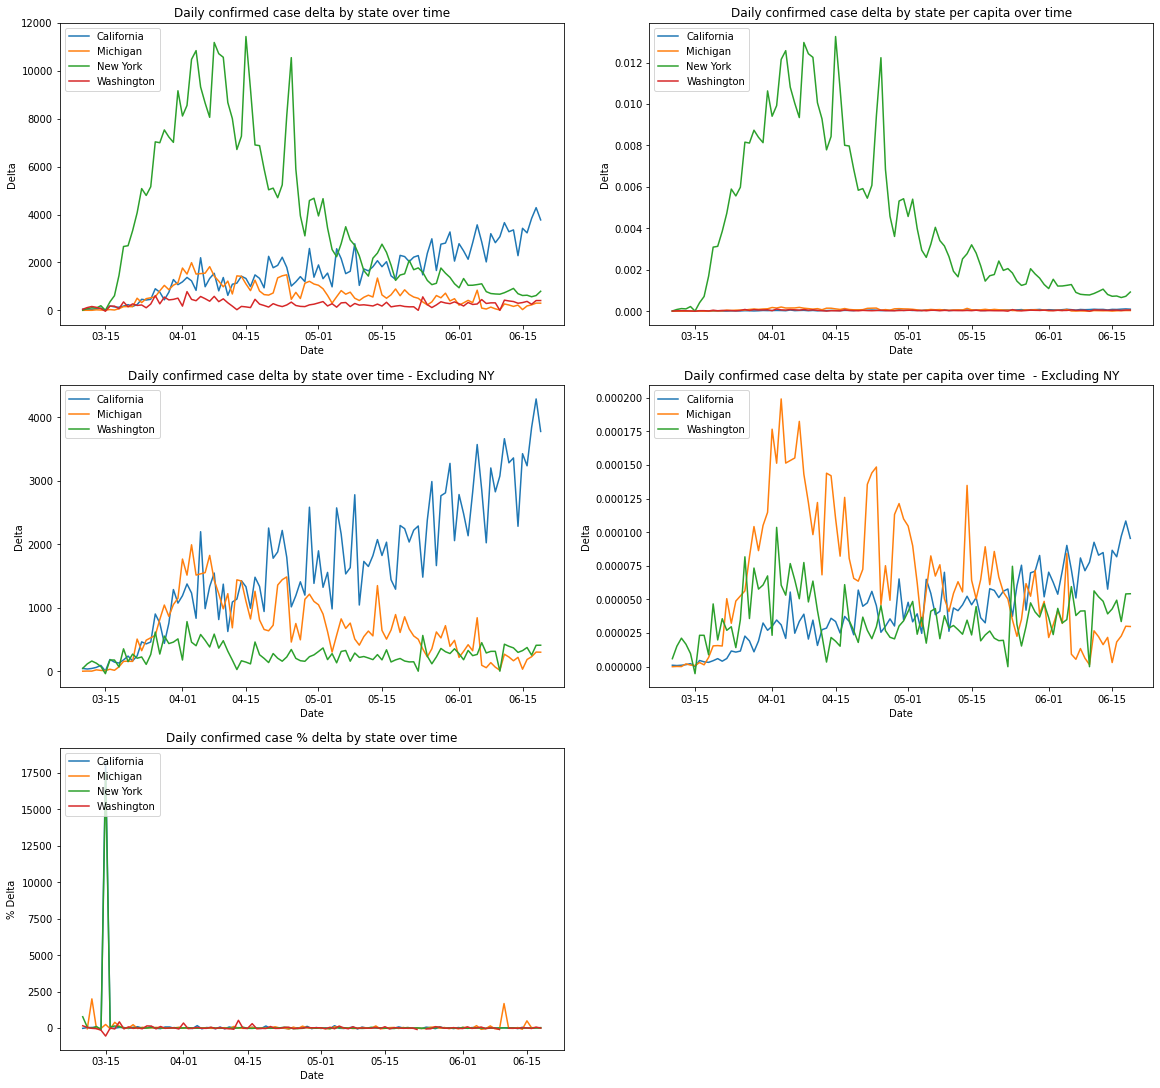

In [12]:
df_states_diffs = df_states.diff(periods=1, axis=1)

states_diffs_per_capita = []
for row_num, row in df_states_diffs.iterrows():
  states_diffs_per_capita.append(
      row/int((df_population['population'][df_population['state'] == row_num])))
df_states_diffs_per_capita = pd.DataFrame(states_diffs_per_capita)

df_states_diffs_retroactive = df_states_diffs.diff(periods=-1, axis=1).multiply(-100)
states_diffs_retroactive = []
for row_num, row in df_states_diffs_retroactive.iterrows():
  states_diffs_retroactive.append(row.div(df_states_diffs.loc[row_num]))
df_states_diffs_retroactive = pd.DataFrame(states_diffs_retroactive)

dfs = [df_states_diffs,
       df_states_diffs_per_capita, 
       df_states_diffs.loc[df_states_diffs.index != 'New York'], 
       df_states_diffs_per_capita.loc[df_states_diffs_per_capita.index != 'New York'],
       df_states_diffs_retroactive]
titles = ['Daily confirmed case delta by state over time', 
          'Daily confirmed case delta by state per capita over time', 
          'Daily confirmed case delta by state over time - Excluding NY',
          'Daily confirmed case delta by state per capita over time  - Excluding NY',
          'Daily confirmed case % delta by state over time']
xlabels = ['Date', 'Date', 'Date', 'Date', 'Date']
ylabels = ['Delta', 'Delta', 'Delta', 'Delta', '% Delta']

plot_data(dfs, titles, xlabels, ylabels, start_date=US_START_DATE)

County-Level Data

In [13]:
counties = ['Oakland, Michigan, US', 'Wayne, Michigan, US', 'Santa Clara, California, US', 'San Francisco, California, US', 'King, Washington, US']
df_counties = df_us[df_us['Combined_Key'].isin(counties)]
df_counties.set_index('Combined_Key', inplace=True)
df_counties = df_counties[df_counties.columns[9:]]
df_counties_diffs = df_counties.diff(periods=1, axis=1)
df_counties_diffs_retroactive = df_counties_diffs.diff(periods=-1, axis=1).multiply(-100)

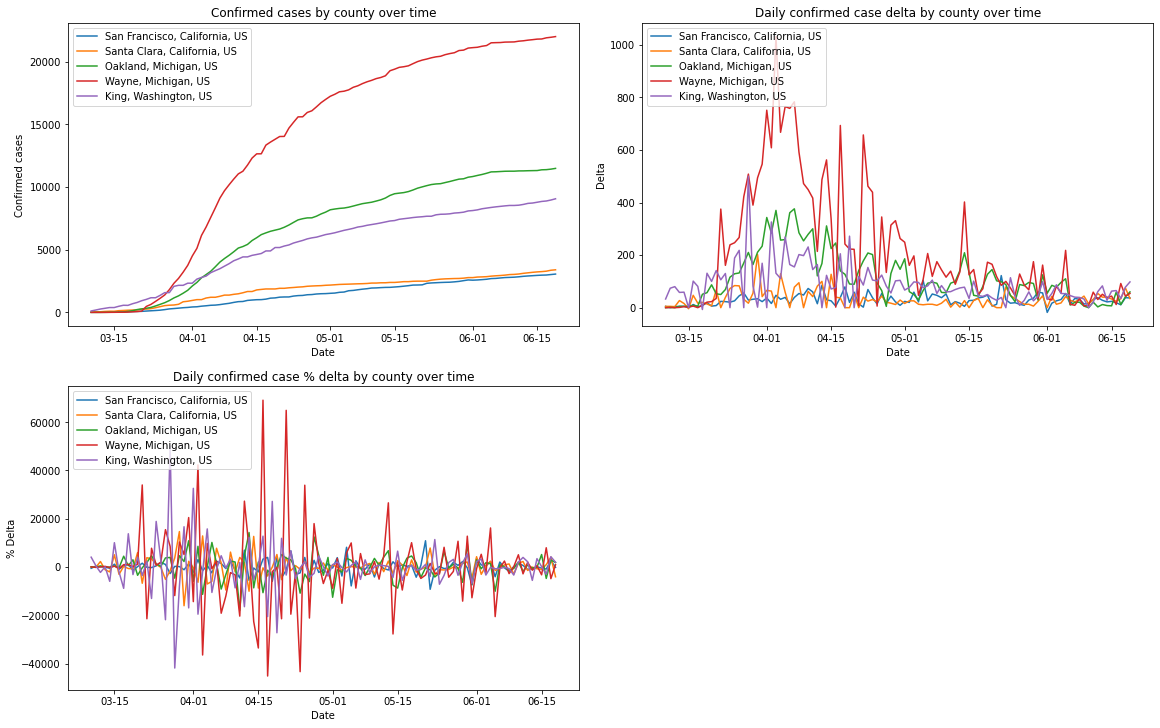

In [14]:
dfs = [df_counties, df_counties_diffs, df_counties_diffs_retroactive]
titles = ['Confirmed cases by county over time',
          'Daily confirmed case delta by county over time',
          'Daily confirmed case % delta by county over time']
xlabels = ['Date', 'Date', 'Date']
ylabels = ['Confirmed cases', 'Delta', '% Delta']

plot_data(dfs, titles, xlabels, ylabels, start_date=US_START_DATE)